In [ ]:
import requests
import json
import math
import pandas as pd
import numpy as np

# Para este notebook solo
import re
import nltk
import spacy
from collections import Counter
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [ ]:
file_path = './clinicaltrials_limpio.csv'
df= pd.read_csv(file_path)

In [ ]:
def normalizar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar puntuación
    texto = re.sub(r'[^\w\s]', '', texto)
    # Eliminar espacios extra
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

# Lista de columnas para normalizar
columnas_para_normalizar = ['BriefSummary', 'BriefTitle', 'DetailedDescription', 'InterventionDescription',
                            'InterventionName', 'Keyword', 'OfficialTitle', 'ArmGroupDescription',
                            'ArmGroupInterventionName', 'ArmGroupLabel', 'InterventionArmGroupLabel',
                            'EligibilityCriteria', 'PrimaryOutcomeMeasure', 'SecondaryOutcomeMeasure']


# Aplicar la función de normalización a cada columna
for columna in columnas_para_normalizar:
    df[columna] = df[columna].dropna().apply(normalizar_texto)



Extracción de Entidades Nombradas (NER)

PERSON: Personas, incluyendo nombres de individuos.

NORP: Grupos nacionales, religiosos o políticos.

FAC: Instalaciones construidas por el hombre, como edificios o puentes.

ORG: Organizaciones, incluyendo compañías, agencias gubernamentales, etc.

GPE: Entidades geopolíticas, como países, ciudades, estados.

LOC: Ubicaciones no GPE, como regiones geográficas y cuerpos de agua.

PRODUCT: Objetos, vehículos, alimentos, etc. (no servicios).

EVENT: Eventos nombrados, como batallas, guerras, desastres naturales, etc.

WORK_OF_ART: Títulos de libros, canciones, películas, etc.

LAW: Documentos legales o nombres de leyes.

LANGUAGE: Cualquier lenguaje hablado o lenguaje de programación.

DATE: Fechas o periodos de tiempo absolutos o relativos.

TIME: Horas o periodos del día.

PERCENT: Porcentajes, incluyendo "%".

MONEY: Cantidad monetaria, incluyendo moneda.

QUANTITY: Medidas de peso, distancia, etc.

ORDINAL: "Primero", "segundo", etc.

CARDINAL: Números que no caen bajo otra categoría.

In [ ]:
# Cargar el modelo de lenguaje de spaCy
nlp = spacy.load('en_core_web_sm')

def extraer_entidades(texto):
    # Procesar el texto con spaCy
    doc = nlp(texto)
    # Extraer entidades y sus etiquetas
    entidades = [(ent.text, ent.label_) for ent in doc.ents]
    return entidades

columnas_para_ner = ['BriefSummary', 'DetailedDescription', 'InterventionDescription',
                      'ArmGroupDescription', 'EligibilityCriteria', 'PrimaryOutcomeMeasure',
                      'SecondaryOutcomeMeasure']

# Aplicar la función de extracción de entidades a cada columna
for columna in columnas_para_ner:
    df[columna+"NER"] = df[columna].dropna().apply(extraer_entidades)

columnas_ner = [col for col in df.columns if col.endswith('NER')]

# Inicializar contadores para cada tipo de entidad
contadores_por_tipo = {}

for columna in columnas_para_ner:
    for fila in df[columna + 'NER'].dropna():
        for ent, tipo in fila:
            if tipo not in contadores_por_tipo:
                contadores_por_tipo[tipo] = Counter()
            contadores_por_tipo[tipo][ent] += 1

# Tipos de entidad específicos para mostrar
tipos_seleccionados = ['NORP', 'PRODUCT', 'PERSON']

# Definir una función para aplicar estilos a los DataFrames
def aplicar_estilo(df):
    return df.style.set_table_styles(
        [{'selector': 'th',
          'props': [('font-size', '12pt'), ('text-align', 'center'), ('font-weight', 'bold'), ('color', 'black'), ('background-color', 'lightgrey')]},
         {'selector': 'td',
          'props': [('text-align', 'center'), ('font-size', '11pt')]}]
    ).background_gradient(cmap='Blues', subset='Frecuencia')

# Crear y mostrar un DataFrame para cada tipo de entidad seleccionado
for tipo in tipos_seleccionados:
    if tipo in contadores_por_tipo:
        # Convertir el contador en un DataFrame y tomar las 5 primeras filas
        df_tipo = pd.DataFrame.from_records(list(contadores_por_tipo[tipo].items()), columns=['Entidad', 'Frecuencia'])
        df_tipo = df_tipo.sort_values(by='Frecuencia', ascending=False).head(5).reset_index(drop=True)

        # Aplicar estilos y mostrar el DataFrame
        print(f"\n{tipo}\n")
        display(aplicar_estilo(df_tipo))
    else:
        print(f"No se encontraron entidades para el tipo '{tipo}'\n")



NORP



,Entidad,Frecuencia
0,american,1087
1,chinese,653
2,cyp3a4,517
3,english,499
4,french,359



PRODUCT



,Entidad,Frecuencia
0,ki67,582
1,109l,176
2,tc99,72
3,mk3475,53
4,cellsmm3,47



PERSON



,Entidad,Frecuencia
0,her2,1258
1,ihc,787
2,trastuzumab herceptin,403
3,brca2,399
4,muga scan,339


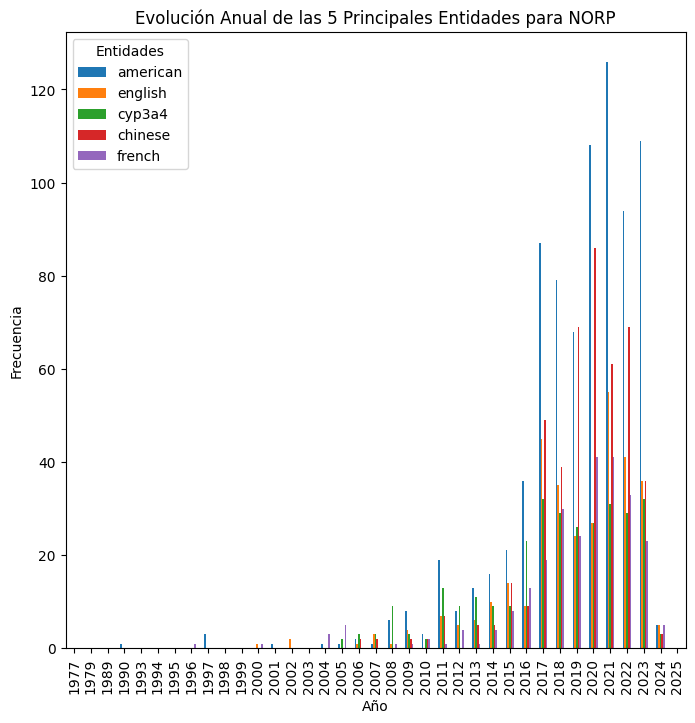

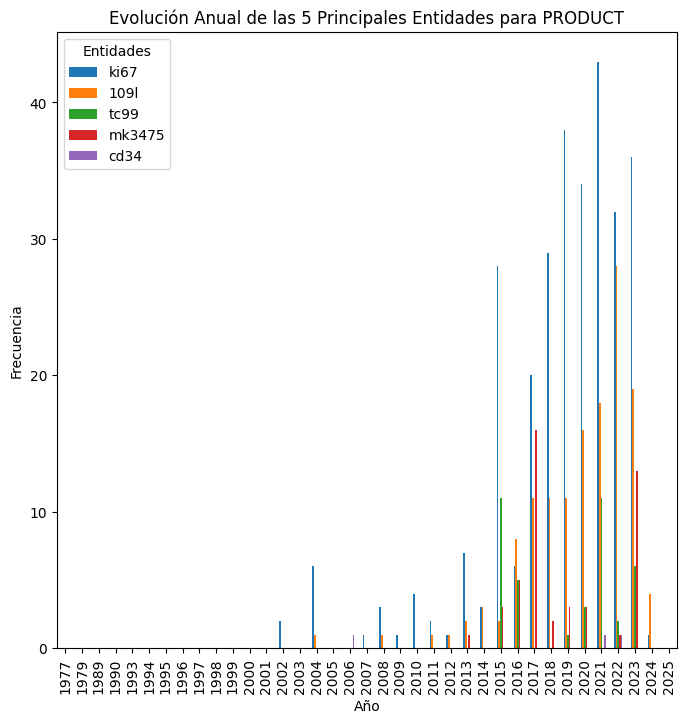

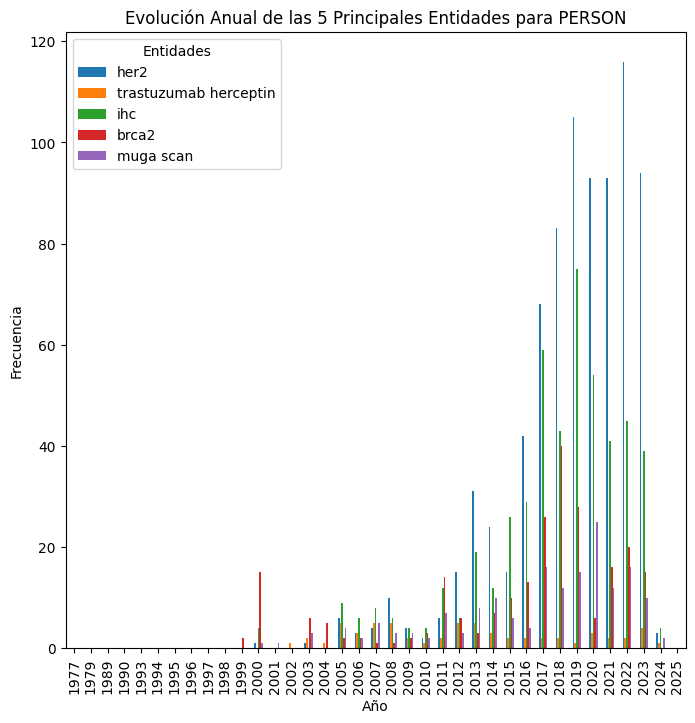

In [18]:

# Cargar el modelo de lenguaje de spaCy
nlp = spacy.load('en_core_web_sm')

for tipo_seleccionado in ['NORP', 'PRODUCT', 'PERSON']:
    contador_entidades = contadores_por_tipo[tipo_seleccionado]

    # Identificar las 5 entidades más comunes
    top_5_entidades = [ent for ent, _ in contador_entidades.most_common(5)]

    # Inicializar un DataFrame para almacenar la evolución de estas entidades
    df_evolucion = pd.DataFrame(index=top_5_entidades)



    # Iterar por año y contar la frecuencia de cada una de estas 5 entidades
    for año in sorted(df['Year'].dropna().astype(int).unique()):
        df_año = df[df['Year'] == año]
        contador_año = Counter()
        for columna_para_ner in columnas_para_ner:
            for fila in df_año[columna_para_ner + 'NER'].dropna():
                for ent, tipo in fila:
                    if tipo == tipo_seleccionado and ent in top_5_entidades:
                        contador_año[ent] += 1
        # Añadir las frecuencias al DataFrame
        df_evolucion[año] = df_evolucion.index.map(contador_año)

    # Transponer el DataFrame para facilitar la visualización
    df_evolucion = df_evolucion.T

    # Graficar
    df_evolucion.plot(kind='bar', figsize=(8, 8))
    plt.title(f'Evolución Anual de las 5 Principales Entidades para {tipo_seleccionado}')
    plt.xlabel('Año')
    plt.ylabel('Frecuencia')
    plt.legend(title='Entidades')
    plt.show()



In [17]:
df_succesful = df[df['SuccessfulCases'] == 'Successful']


# Aplicar la función de extracción de entidades a cada columna
for columna in columnas_para_ner:
    df_succesful[columna+"NER"] = df_succesful[columna].dropna().apply(extraer_entidades)

columnas_ner = [col for col in df_succesful.columns if col.endswith('NER')]

# Inicializar contadores para cada tipo de entidad
contadores_por_tipo = {}

for columna in columnas_para_ner:
    for fila in df_succesful[columna + 'NER'].dropna():
        for ent, tipo in fila:
            if tipo not in contadores_por_tipo:
                contadores_por_tipo[tipo] = Counter()
            contadores_por_tipo[tipo][ent] += 1

# Tipos de entidad específicos para mostrar
tipos_seleccionados = ['NORP', 'PRODUCT', 'PERSON']

# Definir una función para aplicar estilos a los DataFrames
def aplicar_estilo(df_succesful):
    return df_succesful.style.set_table_styles(
        [{'selector': 'th',
          'props': [('font-size', '12pt'), ('text-align', 'center'), ('font-weight', 'bold'), ('color', 'black'), ('background-color', 'lightgrey')]},
         {'selector': 'td',
          'props': [('text-align', 'center'), ('font-size', '11pt')]}]
    ).background_gradient(cmap='Blues', subset='Frecuencia')

# Crear y mostrar un DataFrame para cada tipo de entidad seleccionado
for tipo in tipos_seleccionados:
    if tipo in contadores_por_tipo:
        # Convertir el contador en un DataFrame y tomar las 5 primeras filas
        df_tipo = pd.DataFrame.from_records(list(contadores_por_tipo[tipo].items()), columns=['Entidad', 'Frecuencia'])
        df_tipo = df_tipo.sort_values(by='Frecuencia', ascending=False).head(5).reset_index(drop=True)

        # Aplicar estilos y mostrar el DataFrame
        print(f"\n{tipo}\n")
        display(aplicar_estilo(df_tipo))
    else:
        print(f"No se encontraron entidades para el tipo '{tipo}'\n")


<ipython-input-17-faf83abec2fc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_succesful[columna+"NER"] = df_succesful[columna].dropna().apply(extraer_entidades)



NORP



,Entidad,Frecuencia
0,american,375
1,english,259
2,cyp3a4,203
3,chinese,186
4,french,144



PRODUCT



,Entidad,Frecuencia
0,ki67,213
1,109l,42
2,tc99,35
3,cd34,20
4,mk3475,20



PERSON



,Entidad,Frecuencia
0,her2,373
1,trastuzumab herceptin,275
2,ihc,264
3,brca2,181
4,muga scan,172


Topic Modeling Latent Dirichlet Allocation (LDA)

In [ ]:
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Lista de palabras a excluir
palabras_excluidas = ['cancer', 'breast', 'women', 'patients']  # Palabras específicas a excluir

def preprocesar(texto):
    resultado = []
    for token in gensim.utils.simple_preprocess(texto):
        if token not in stop_words and token not in palabras_excluidas:
            resultado.append(token)
    return resultado

# Preprocesar cada documento


columnas_para_lda = ['BriefSummary', 'DetailedDescription', 'PrimaryOutcomeMeasure',
                      'SecondaryOutcomeMeasure']

# Aplicar la función de extracción de entidades a cada columna
for columna in columnas_para_lda:
    datos_preprocesados = df[columna].dropna().map(preprocesar)


# Crear Diccionario
diccionario = corpora.Dictionary(datos_preprocesados)

# Crear Corpus
textos = datos_preprocesados

# Término Frecuencia Documento (Term Document Frequency)
corpus = [diccionario.doc2bow(texto) for texto in textos]

# Número de temas
num_topics = 10

# Construir el modelo LDA
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=diccionario,
                                       num_topics=num_topics)

# Crear un DataFrame para los temas
datos_temas = {'Tema': [], 'Palabras Clave': []}
for idx, topic in lda_model.print_topics(-1):
    datos_temas['Tema'].append(idx)
    datos_temas['Palabras Clave'].append(topic)

df_temas = pd.DataFrame(datos_temas)

# Definir una función para aplicar estilos al DataFrame
def aplicar_estilo(df):
    return df.style.set_table_styles(
        [{'selector': 'th',
          'props': [('font-size', '12pt'), ('text-align', 'center'), ('font-weight', 'bold'), ('color', 'black'), ('background-color', 'lightgrey')]},
         {'selector': 'td',
          'props': [('text-align', 'left'), ('font-size', '11pt')]}]
    ).hide_index()

# Aplicar estilos y mostrar el DataFrame
df_estilizado = aplicar_estilo(df_temas)
df_estilizado


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-14-d4557997237b>:59: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  ).hide_index()


Tema,Palabras Clave
0,"0.063*""survival"" + 0.052*""overall"" + 0.026*""change"" + 0.023*""os"" + 0.013*""disease"" + 0.013*""quality"" + 0.013*""activity"" + 0.012*""months"" + 0.011*""life"" + 0.011*""rate"""
1,"0.020*""treatment"" + 0.015*""events"" + 0.015*""number"" + 0.014*""response"" + 0.014*""adverse"" + 0.014*""dose"" + 0.014*""participants"" + 0.012*""nonserious"" + 0.012*""diagnostic"" + 0.011*""safety"""
2,"0.021*""area"" + 0.017*""curve"" + 0.017*""phase"" + 0.013*""secondary"" + 0.013*""cells"" + 0.013*""auc"" + 0.012*""cmax"" + 0.012*""rate"" + 0.011*""tcr"" + 0.011*""dose"""
3,"0.021*""quality"" + 0.020*""life"" + 0.017*""tumor"" + 0.014*""cea"" + 0.012*""assessment"" + 0.012*""time"" + 0.012*""patient"" + 0.012*""change"" + 0.011*""treatment"" + 0.010*""recurrence"""
4,"0.056*""rate"" + 0.038*""response"" + 0.038*""cd"" + 0.036*""objective"" + 0.030*""orr"" + 0.024*""cmax"" + 0.020*""concentration"" + 0.020*""activation"" + 0.019*""maximum"" + 0.014*""phase"""
5,"0.117*""response"" + 0.062*""rate"" + 0.035*""recist"" + 0.033*""overall"" + 0.030*""complete"" + 0.022*""orr"" + 0.020*""clinical"" + 0.019*""criteria"" + 0.017*""evaluation"" + 0.017*""partial"""
6,"0.028*""number"" + 0.024*""change"" + 0.022*""anxiety"" + 0.019*""participants"" + 0.018*""assessed"" + 0.018*""intervention"" + 0.015*""using"" + 0.014*""care"" + 0.014*""selfefficacy"" + 0.014*""changes"""
7,"0.029*""toxicity"" + 0.029*""response"" + 0.024*""incidence"" + 0.021*""assessed"" + 0.020*""adverse"" + 0.017*""rate"" + 0.015*""pfs"" + 0.013*""survival"" + 0.013*""immunologic"" + 0.013*""progressionfree"""
8,"0.054*""events"" + 0.049*""adverse"" + 0.024*""safety"" + 0.020*""treatment"" + 0.020*""number"" + 0.018*""incidence"" + 0.014*""concentration"" + 0.014*""part"" + 0.013*""pharmacokinetic"" + 0.013*""pk"""
9,"0.054*""survival"" + 0.037*""pfs"" + 0.031*""free"" + 0.030*""progression"" + 0.022*""progressionfree"" + 0.018*""quality"" + 0.018*""time"" + 0.017*""life"" + 0.016*""qol"" + 0.012*""tumor"""


In [ ]:
# Obtener los tres temas dominantes para cada documento
dominant_topics = []
for i, row_list in enumerate(lda_model[corpus]):
    row = sorted(row_list, key=lambda x: (x[1]), reverse=True)
    top_three_topics = row[:3]  # Obtener los tres temas principales
    top_three_topics_info = []

    for topic_num, prop_topic in top_three_topics:
        wp = lda_model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        top_three_topics_info.append((int(topic_num), round(prop_topic, 4), topic_keywords))

    dominant_topics.append((i, top_three_topics_info))

# Crear un nuevo DataFrame
df_dominant_topics = pd.DataFrame(dominant_topics, columns=['Documento', 'Top 3 Temas'])

# Añadir la columna de Top 3 Temas
df['Temas'] = df_dominant_topics['Top 3 Temas'].apply(lambda x: [item[0] for item in x])

In [ ]:
from google.colab import files
# Especifica el path del CSV
ruta_archivo = './clinicaltrials_temas.csv'

# Guardar el DataFrame como CSV
df.to_csv(ruta_archivo, index=False, header=True)
files.download('clinicaltrials_temas.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df_succesful = df[df['SuccessfulCases'] == 'Successful']


# Aplicar la función de extracción de entidades a cada columna
for columna in columnas_para_lda:
    datos_preprocesados = df_succesful[columna].dropna().map(preprocesar)


# Crear Diccionario
diccionario = corpora.Dictionary(datos_preprocesados)

# Crear Corpus
textos = datos_preprocesados

# Término Frecuencia Documento (Term Document Frequency)
corpus = [diccionario.doc2bow(texto) for texto in textos]

# Número de temas
num_topics = 10

# Construir el modelo LDA
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=diccionario,
                                       num_topics=num_topics)

# Crear un DataFrame para los temas
datos_temas = {'Tema': [], 'Palabras Clave': []}
for idx, topic in lda_model.print_topics(-1):
    datos_temas['Tema'].append(idx)
    datos_temas['Palabras Clave'].append(topic)

df_temas = pd.DataFrame(datos_temas)

# Definir una función para aplicar estilos al DataFrame
def aplicar_estilo(df):
    return df.style.set_table_styles(
        [{'selector': 'th',
          'props': [('font-size', '12pt'), ('text-align', 'center'), ('font-weight', 'bold'), ('color', 'black'), ('background-color', 'lightgrey')]},
         {'selector': 'td',
          'props': [('text-align', 'left'), ('font-size', '11pt')]}]
    ).hide_index()

# Aplicar estilos y mostrar el DataFrame
df_estilizado = aplicar_estilo(df_temas)
df_estilizado


<ipython-input-106-b71906b83631>:41: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  ).hide_index()


Tema,Palabras Clave
0,"0.018*""metastasis"" + 0.015*""response"" + 0.014*""ps"" + 0.014*""ldh"" + 0.014*""prognostic"" + 0.013*""rate"" + 0.013*""intervention"" + 0.011*""brain"" + 0.008*""tumor"" + 0.008*""determining"""
1,"0.024*""life"" + 0.024*""quality"" + 0.016*""survival"" + 0.016*""diagnosis"" + 0.013*""psychosocial"" + 0.013*""acute"" + 0.013*""laboratory"" + 0.013*""data"" + 0.013*""abnormal"" + 0.013*""impact"""
2,"0.022*""survival"" + 0.022*""overall"" + 0.015*""cn"" + 0.015*""number"" + 0.015*""recurrence"" + 0.015*""blood"" + 0.015*""cells"" + 0.015*""cm"" + 0.015*""metastases"" + 0.008*""surgery"""
3,"0.023*""insomnia"" + 0.023*""participants"" + 0.016*""among"" + 0.016*""severity"" + 0.016*""bc"" + 0.016*""scale"" + 0.016*""impact"" + 0.016*""experiencing"" + 0.016*""number"" + 0.016*""score"""
4,"0.024*""rate"" + 0.016*""score"" + 0.016*""attitudes"" + 0.016*""social"" + 0.009*""therapy"" + 0.009*""decision"" + 0.009*""barriers"" + 0.009*""cells"" + 0.009*""survival"" + 0.009*""cancers"""
5,"0.029*""number"" + 0.023*""treatment"" + 0.018*""percentage"" + 0.018*""participants"" + 0.012*""results"" + 0.012*""axillary"" + 0.012*""positive"" + 0.012*""months"" + 0.012*""toxicity"" + 0.012*""clinical"""
6,"0.017*""positivity"" + 0.017*""days"" + 0.017*""surgical"" + 0.017*""third"" + 0.017*""er"" + 0.017*""specimens"" + 0.017*""therapy"" + 0.017*""tumor"" + 0.017*""overall"" + 0.013*""appropriate"""
7,"0.020*""number"" + 0.020*""visits"" + 0.020*""risk"" + 0.014*""care"" + 0.014*""participants"" + 0.014*""clinic"" + 0.014*""treatment"" + 0.014*""health"" + 0.014*""prescribed"" + 0.014*""oncology"""
8,"0.027*""metastatic"" + 0.020*""pain"" + 0.014*""impact"" + 0.014*""distress"" + 0.014*""fluorescence"" + 0.014*""imaging"" + 0.014*""determine"" + 0.014*""optical"" + 0.014*""life"" + 0.014*""therapy"""
9,"0.033*""participants"" + 0.017*""cd"" + 0.017*""response"" + 0.009*""mrna"" + 0.009*""creactive"" + 0.009*""including"" + 0.009*""markers"" + 0.009*""caspase"" + 0.009*""protein"" + 0.009*""estrogen"""
